# Bootstrapped error and prediction intervals for regression models
An example of bootstrapped error margin calculations for a dataset exhibiting heteroskedasticity

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from plotnine import ggplot, aes, labs, theme, \
    geom_line, geom_point, geom_ribbon, facet_wrap

from bootstrap_intervals import bootstrap_intervals
from regression_diagnostics import RegressionDiagnostics

import warnings
warnings.filterwarnings('ignore')

## Build dataset  
Generate a dataset with two groups and heteroskedastic noise

In [2]:
base = np.arange(0, 4 * np.pi, 0.02)
grp_1 = np.random.default_rng().choice(base, size=len(base), replace=True, shuffle=False)
grp_2 = np.random.default_rng().choice(base, size=len(base), replace=True, shuffle=False)

df = pd.DataFrame(zip(np.repeat([0, 1],len(base)),
                      np.concatenate([grp_1, grp_2])),
                  columns=["grp", "x"])

np.random.seed(42)
df = df.assign(
    rnorm_1=np.random.normal(0, 0.25, len(base) * 2),
    rnorm_2=np.random.normal(1, 0.5, len(base) * 2),
    y_base=lambda i: np.sin(i.x) + i.x * 0.2 + i.grp * 2,
    y = lambda i: i.y_base + np.cos(i.x * (1 - i.grp) / 3) * (1 + i.grp) * i.rnorm_1 * i.rnorm_2
)
df.head()

,grp,x,rnorm_1,rnorm_2,y_base,y
0,0,1.18,0.124179,0.647494,1.160606,1.234871
1,0,8.22,-0.034566,0.972115,2.577760,2.608689
2,0,8.20,0.161922,1.279163,2.580731,2.390629
3,0,5.72,0.380757,1.038003,0.610118,0.479854
4,0,8.70,-0.058538,1.269378,2.402969,2.475118


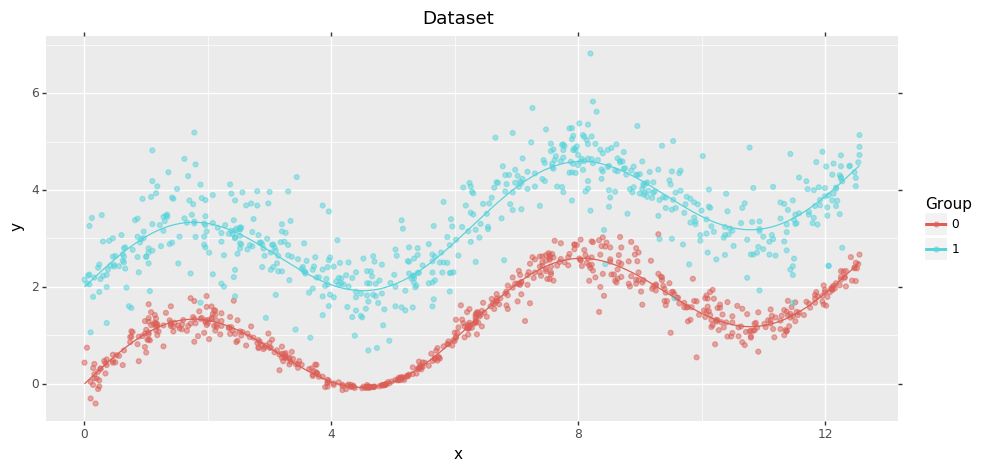

<ggplot: (-9223371922533830421)>

In [3]:
# Plot dataset
(ggplot(df, aes(x="x", y="y", colour="factor(grp)")) +
 geom_point(alpha=0.5, size=1.5) +
 geom_line(aes(y="y_base")) +
 labs(title="Dataset",
      color="Group") +
 theme(figure_size=(11,5))
)

## Build model
Fit a LightGBM model (using default settings)

In [4]:
train, test = train_test_split(df[["grp", "x", "y"]], test_size=0.2)

X_train = train[["grp", "x"]]
y_train = train["y"]
X_test = test[["grp", "x"]]
y_test = test[["y"]]

In [5]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Diagnostics
The diagnostic plots confirm heteroskedacity in the residuals.

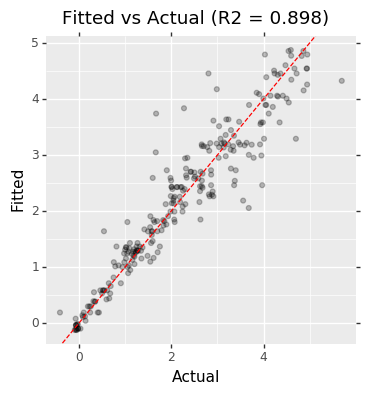

<ggplot: (-9223371922532436592)>

In [6]:
diagnostics = RegressionDiagnostics(lgb_model)
diagnostics.fit(X_test, y_test)
diagnostics.fitted_actual()

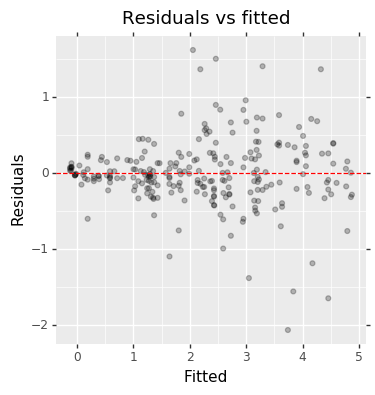

<ggplot: (114322375474)>

In [7]:
diagnostics.residuals_fitted()

## Error margins  
Calculate error margins on the test data and apply back to predicted values for the whole data set.

In [8]:
error_margins = bootstrap_intervals(
    model=lgb_model,
    X_ref=X_test,
    y_ref=y_test,
    X_new=df[["grp", "x"]],
    categorical_features=[],
    nn_weights=None,
    alpha=0.95,
    reps=100,
    k=15)

In [9]:
error_margins_df = pd.concat([df.reset_index(),
          error_margins], 1).set_index("index")
error_margins_df.head()

,grp,x,rnorm_1,rnorm_2,y_base,y,yhat,lower_err,upper_err,lower_pred,upper_pred
index,,,,,,,,,,,
0,0,1.18,0.124179,0.647494,1.160606,1.234871,1.240305,1.021751,1.458859,0.799099,1.681511
1,0,8.22,-0.034566,0.972115,2.577760,2.608689,2.627582,2.299040,2.956123,1.977627,3.277537
2,0,8.20,0.161922,1.279163,2.580731,2.390629,2.513383,2.188855,2.837911,1.863428,3.163338
3,0,5.72,0.380757,1.038003,0.610118,0.479854,0.587616,0.475311,0.699920,0.133617,1.041614
4,0,8.70,-0.058538,1.269378,2.402969,2.475118,2.593723,2.209322,2.978125,1.841156,3.346291


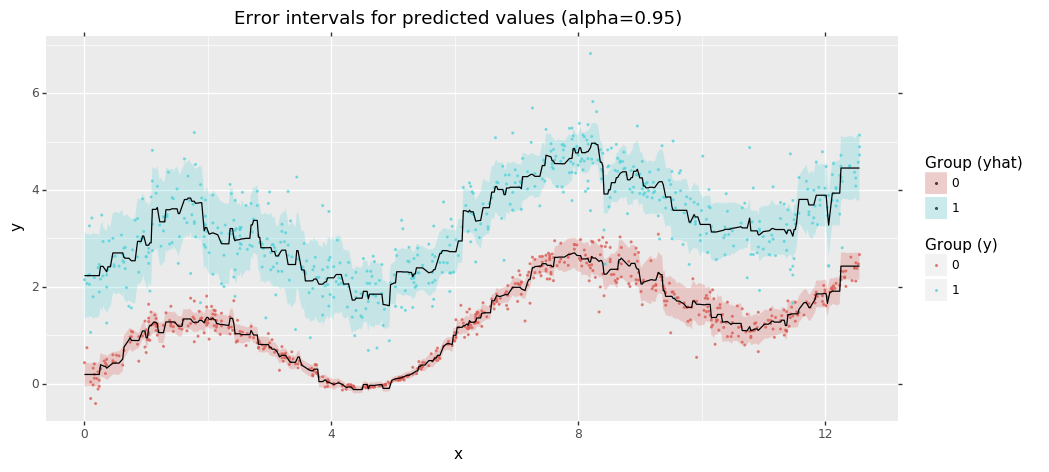

<ggplot: (114322311670)>

In [10]:
(ggplot(error_margins_df,
        aes(x="x", fill="factor(grp)")) +
 geom_ribbon(aes(x="x", ymin="lower_err", ymax="upper_err"),
             alpha=0.25) +
 geom_point(aes(y="y", colour="factor(grp)"), alpha=0.7, size=0.25) +
 geom_line(aes(y="yhat")) +
 labs(title="Error intervals for predicted values (alpha=0.95)",
      fill="Group (yhat)",
      color="Group (y)",
      y="y") +
 theme(figure_size=(11, 5))
)

### Impact of number of nearest neighbours
Smaller number of nearest neighbours = more localised error margins  
Largner number of nearest neighbours = error margins closer to global error

In [11]:
# Experiment using a range of k nearest neighbours
num_neighbours = [15, 100, len(X_test)]

nn_result = pd.DataFrame()

for k in num_neighbours:
    error_margins = bootstrap_intervals(
        model=lgb_model,
        X_ref=X_test,
        y_ref=y_test,
        X_new=df[["grp", "x"]],
        categorical_features=[],
        nn_weights=None,
        alpha=0.95,
        reps=1000,
        k=k)
    
    error_margins_df = pd.concat([df.reset_index(),
                               error_margins], 1).set_index("index").assign(
        k = k)
        
    nn_result = pd.concat([nn_result, error_margins_df])   

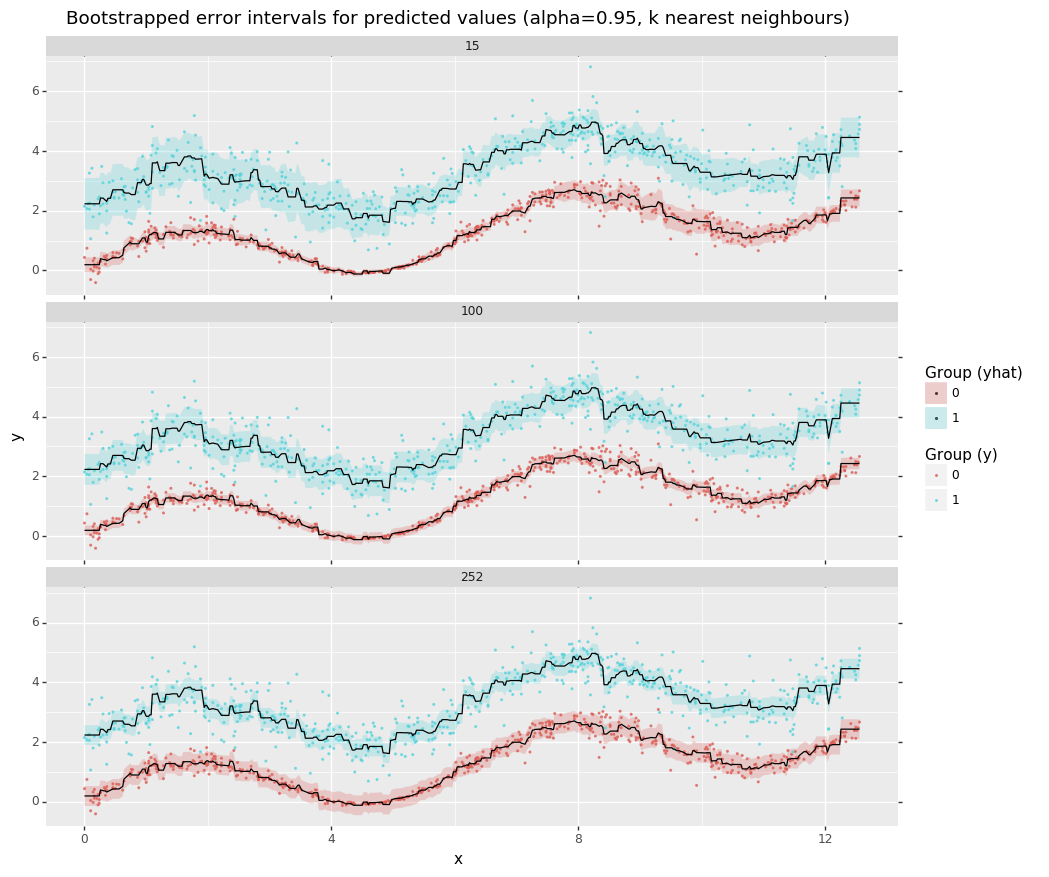

<ggplot: (114322320879)>

In [12]:
# Plot results
(ggplot(nn_result,
        aes(x="x", fill="factor(grp)")) +
 geom_ribbon(aes(x="x", ymin="lower_err", ymax="upper_err"),
             alpha=0.25) +
 geom_point(aes(y="y", colour="factor(grp)"), alpha=0.7, size=0.25) +
 geom_line(aes(y="yhat")) +
 labs(title="Bootstrapped error intervals for predicted values (alpha=0.95, k nearest neighbours)",
      fill="Group (yhat)",
      color="Group (y)",
      y="y") +
 facet_wrap("~k", ncol=1) +
 theme(figure_size=(11, 10))
)